## Ejemplo de transformada de Fourier para resolver una ecuación diferencial parcial. En este caso, resolveremos la ecuación de calor.

### Ecuaciones
La ecuación de calor en una dimensión es:
$$
u_t = \alpha u_{xx}
$$
Esta ecuacion descrube la distribución de temperatura $u(x,t)$ a lo largo de una barra a lo largo del tiempo, donde $\alpha$ es la difusividad térmica.
Lo esperable es que la temperatura inicial se distribuya a lo largo de la barra y con el tiempo se estabilice.
### Condiciones iniciales
Condición inicial: $u(x,0) = f(x)$, donde $f(x)$ es una función dada que describe la distribución inicial de temperatura.
### Solución usando la transformada de Fourier
1. **Aplicar la transformada de Fourier**: Tomamos la transformada de Fourier
$$
\hat{u}(\kappa,t) = \int_{-\infty}^{\infty} u(x,t) e^{-i\kappa x} \, dx
$$
Aplicando la transformada de Fourier a la ecuación de calor, obtenemos:
$$
\hat{u}_t = -\alpha \kappa^2 \hat{u}
$$
Notar que $\hat{u}(\kappa,t)$ es una función de $\kappa$ y $t$. Esta es una ecuación diferencial ordinaria en el tiempo $t$ para cada modo $\kappa$.

2. **Resolver la ecuación diferencial ordinaria**: La solución general de esta ecuación es:
$$
\hat{u}(\kappa,t) = \hat{u}(\kappa,0) e^{-\alpha \kappa^2 t}
$$
donde $\hat{u}(\kappa,0)$ es la transformada de Fourier de la condición inicial $f(x)$:
$$
\hat{u}(\kappa,0) = \int_{-\infty}^{\infty} f(x) e^{-i\kappa x} \, dx
$$
3. **Aplicar la transformada inversa de Fourier**: Finalmente, aplicamos la transformada inversa de Fourier para obtener $u(x,t)$:
$$
u(x,t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} \hat{u}(\kappa,t) e^{i\kappa x} \, d\kappa
$$
Sustituyendo $\hat{u}(\kappa,t)$, obtenemos:
$$
u(x,t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} \hat{u}(\kappa,0) e^{i\kappa x -\alpha \kappa^2 t} \, d\kappa
$$
Esta integral se llama integral Gaussiana y su solucion se llama kernel de difusion. Al convolucionar la condicion inicial con este kernel, obtenemos la solucion de la ecuacion de calor. Es como si la condicion inicial se "difuminara" a lo largo del tiempo. O al menos eso entendi


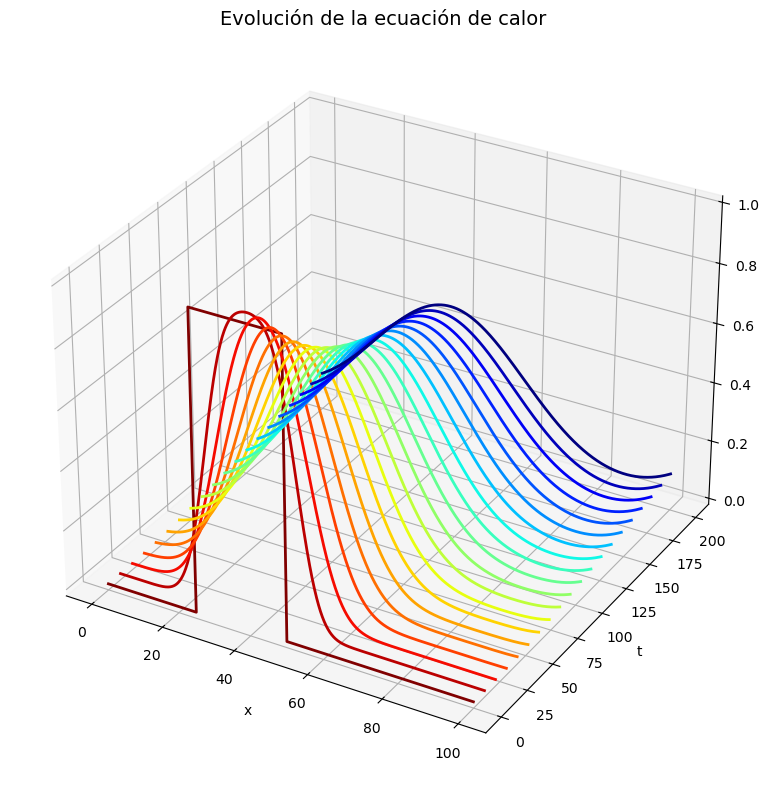

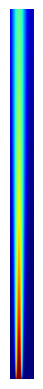

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint

alpha = 1
L = 100
N = 1000
dx = L / N
x = np.arange(0, L, dx)
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx) # multiplos de la frecuencia fundamental
# Condicion inicial
u0 = np.zeros_like(x)
u0[N//4:N//2] = 1 # onda cuadrada entre x1=L/4 y x2=L/2
u0_hat = np.fft.fft(u0) # transformada de la condicion inicial

# Segun el libro, odeint no se la banca mucho con numeros complejos asi que concatena 
# la parte real con la imaginaria para obtener un vector real de 2N elementos
u0_hat_2n = np.concatenate([u0_hat.real, u0_hat.imag])

# Ahora simulamos la evolucion con odeint
dt = 0.1 # paso temporal de un segundo
t = np.arange(0, 200, dt)
def du_hat_dt(u_hat_2n, t, alpha, kappa):
    N = len(u_hat_2n)//2
    u_hat = u_hat_2n[:N] + 1j*u_hat_2n[N:] # reconstruyo el vector complejo
    du_hat = -alpha * (kappa**2) * u_hat # ecuacion diferencial en espacio de Fourier
    return np.concatenate([du_hat.real, du_hat.imag]) # devuelvo la parte real e imaginaria por separado

u0_hat_2n = odeint(du_hat_dt, u0_hat_2n, t, args=(alpha, kappa))
u_hat = u0_hat_2n[:,:N] + 1j*u0_hat_2n[:,N:] # reconstruyo el vector complejo

u = np.zeros_like(u_hat)
for k in range(len(t)):
    u[k,:] = np.fft.ifft(u_hat[k,:]) # transformada inversa
u = u.real # me quedo con la parte real

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Seleccionar algunos instantes de tiempo para plotear
t_indices = np.linspace(0, len(t)-1, 20, dtype=int)
colors = plt.cm.jet(np.linspace(1, 0, len(t_indices))) # invertido para que haya colores calidos en el principio

for i, t_idx in enumerate(t_indices):
    ax.plot(x, np.full_like(x, t[t_idx]), u[t_idx, :], 
            color=colors[i], linewidth=2)

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Evolución de la ecuación de calor', fontsize=14)
plt.tight_layout()
plt.show()

# imagen 2D "vista desde arriba"
plt.figure()
plt.imshow(np.flipud(u),cmap='jet')
plt.axis('off')
plt.show()